In [1]:
import sleep_study as ss
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from glob import glob
import seaborn as sns
from sklearn.model_selection import train_test_split

In [2]:
ss.init()

age information stored in /Users/FernandoQin/Desktop/CMU/CMU_sleep_study/examples/age_file.csv


In [3]:
!pwd

/Users/FernandoQin/Desktop/CMU/CMU_sleep_study/examples


## first kid edf file re-sampling and reshaping

In [4]:
data, labels = ss.data.get_sleep_eeg_and_stages('1_4789')
print(data.shape)
print(labels.shape)
#data is (num events) by (num channels) by (30s x ss.info.REFERENCE_FREQ)

(854, 1, 3000)
(854,)


In [5]:
data = data.reshape(854, 3000, 1)

In [6]:
data.shape

(854, 3000, 1)

In [7]:
#swap the axes of the data to match the cnn model data 
#for i in data:
    #print(i)

In [8]:
print(type(data))
print(type(labels))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [9]:
print(data.shape)
print(labels.shape)

(854, 3000, 1)
(854,)


In [10]:
!pwd

/Users/FernandoQin/Desktop/CMU/CMU_sleep_study/examples


In [11]:
np.savez('1_4789.npz', x=data,  y=labels)

In [12]:
arrs = np.load('1_4789.npz')
print(arrs['x'].shape)
print(arrs['y'].shape)

(854, 3000, 1)
(854,)


## second kid edf file re-sampling and reshaping


In [13]:
data, labels = ss.data.get_sleep_eeg_and_stages('22_23233')

In [14]:
print(data.shape)
print(labels.shape)
#data is (num events) by (num channels) by (30s x ss.info.REFERENCE_FREQ)

(869, 1, 3000)
(869,)


In [15]:
data = data.reshape(869, 3000, 1)

In [16]:
print(data.shape)
print(labels.shape)

(869, 3000, 1)
(869,)


In [17]:
np.savez('22_23233.npz', x=data,  y=labels)

## third kid edf file re-sampling and reshaping


In [18]:
data, labels = ss.data.get_sleep_eeg_and_stages('25_10579')

In [47]:
print(data.shape)
print(labels.shape)
#data is (num events) by (num channels) by (30s x ss.info.REFERENCE_FREQ)

(1063, 1, 3000)
(1063,)


In [48]:
data = data.reshape(1063, 3000, 1)

In [49]:
print(data.shape)
print(labels.shape)

(1063, 3000, 1)
(1063,)


In [50]:
#print(np.squeeze(data).shape)

In [86]:
np.savez('25_10579.npz', x=data,  y=labels)

# Real stuff begins here

In [4]:
#path for the kids data
base_path = "/Users/FernandoQin/Desktop/CMU/CMU_sleep_study/physionet.org/files/nch-sleep/0.1.0/Sleep_Data"
#grab the files and their ids
files = sorted(glob(os.path.join(base_path, "*.edf")))
ids = sorted(list(set([x.split("/")[-1][:-4] for x in files])))

In [5]:
#split by test and train/val subject
train_val_ids, test_ids = train_test_split(ids, test_size=0.15, random_state=1338)
#split by train,val subject
train_ids, val_ids = train_test_split(train_val_ids, test_size=0.1, random_state=1337)

In [6]:
print(train_ids)

['91_15028', '16_24241', '25_10579', '7_12595', '28_15280', '22_23233', '10_22339']


### SMOTE on the training dataset

In [7]:
total_label = []
total_data = np.arange(3000).reshape((1,3000))

In [8]:
print(total_data.shape)

(1, 3000)


In [9]:
#downsample and reshape all the kids data
for one_id in ids:
    data, labels = ss.data.get_sleep_eeg_and_stages(one_id)
    if one_id in train_ids:
        #to see the label distribution of the training set
        total_label = np.concatenate((total_label, labels), axis = 0)
        total_data = np.concatenate((total_data, np.squeeze(data)), axis = 0)
    #only save test and val subjects to npz files
    else:
        first_dim = data.shape[0]
        data = data.reshape(first_dim, 3000, 1)
        np.savez(one_id, x=data,  y=labels)

In [10]:
len(total_label)

6664

In [11]:
total_data = total_data[1:,:]

In [12]:
total_data.shape

(6664, 3000)

In [13]:
total_label.shape

(6664,)

## plot and summarize the original dist of labels 

In [14]:
from collections import Counter

In [15]:
counter = Counter(total_label)
for k,v in counter.items():
    per = v / len(total_label) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=1586 (23.800%)
Class=1, n=191 (2.866%)
Class=2, n=2063 (30.957%)
Class=3, n=1664 (24.970%)
Class=4, n=1160 (17.407%)


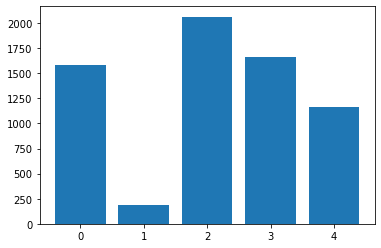

In [16]:
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

### use SMOTE  and RandomUnderSampler to oversample and then undersample

In [17]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder
from imblearn.pipeline import Pipeline

Class=0, n=2063 (20.000%)
Class=1, n=2063 (20.000%)
Class=2, n=2063 (20.000%)
Class=3, n=2063 (20.000%)
Class=4, n=2063 (20.000%)


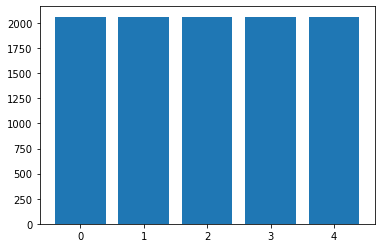

In [18]:
# label encode the target variable
total_label = LabelEncoder().fit_transform(total_label)

# transform the dataset
total = len(total_label)
minor = total//10
major = total - 4 * minor
oversample = SMOTE()
#strategy = {0:int(0.25*total), 1:int(0.1*total), 2:2063, 3:int(0.25*total), 4:int(0.25*total)}
#undersample = RandomUnderSampler(sampling_strategy=strategy)
#steps = [('o', oversample), ('u', undersample)]
steps = [('o', oversample)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(total_data, total_label)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

    # plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [19]:
print(X.shape)

(10315, 3000)


In [20]:
print(y.shape)

(10315,)


### save the resampled training dataset to a local file

In [21]:
#reshape X
X = X.reshape(X.shape[0], X.shape[1], 1)
print(X.shape)

(10315, 3000, 1)


In [22]:
#split the balanced training set
splited_data_array = np.array_split(X, len(train_ids))
splited_label_array = np.array_split(y, len(train_ids))

In [23]:
#to make sure the splitting process works
for i in range(len(train_ids)):
    print(splited_data_array[i].shape)
    print(splited_label_array[i].shape)

(1474, 3000, 1)
(1474,)
(1474, 3000, 1)
(1474,)
(1474, 3000, 1)
(1474,)
(1474, 3000, 1)
(1474,)
(1473, 3000, 1)
(1473,)
(1473, 3000, 1)
(1473,)
(1473, 3000, 1)
(1473,)


In [24]:
for i in range(len(train_ids)):
    np.savez('training_' + str(i), x = splited_data_array[i],  y = splited_label_array[i])

### Grab both the val and test dicts

In [25]:
# #grab val and test subject
# base_path = "/Users/FernandoQin/Desktop/CMU/CMU_sleep_study/examples"

# training_smote = sorted(glob(os.path.join(base_path, "training_smote.npz")))
# train_id = sorted(list(set([x.split("/")[-1][:-4] for x in training_smote])))


# #grab the files and their ids
# files = sorted(glob(os.path.join(base_path, "*.npz")))
# ids = sorted(list(set([x.split("/")[-1][:-4] for x in files])))
# #get rid of the last balanced training set
# ids = ids[:-1]

# #get the balanced training set
# train = [x for x in files if x.split("/")[-1][:-4] in train_id]

# #split by val,test subject
# test_ids, val_ids = train_test_split(ids, test_size=0.5, random_state=1337)
# val, test = [x for x in files if x.split("/")[-1][:-4] in val_ids],\
#                    [x for x in files if x.split("/")[-1][:-4] in test_ids]

# train_dict = {k: np.load(k) for k in train}
# test_dict = {k: np.load(k) for k in test}
# val_dict = {k: np.load(k) for k in val}

In [26]:
#print(train_dict)

In [27]:
#print(val_dict)

In [28]:
#grab val and test subject
base_path = "/Users/FernandoQin/Desktop/CMU/CMU_sleep_study/examples"

#grab the files and their ids
files = sorted(glob(os.path.join(base_path, "*.npz")))
ids = sorted(list(set([x.split("/")[-1][:-4] for x in files])))

train_ids = [x for x in ids if 'training' in x]
test_val_ids = [x for x in ids if 'training' not in x]


#get the balanced training set
train = [x for x in files if x.split("/")[-1][:-4] in train_ids]

#split by val,test subject
test_ids, val_ids = train_test_split(test_val_ids, test_size=0.5, random_state=1337)
val, test = [x for x in files if x.split("/")[-1][:-4] in val_ids],\
                   [x for x in files if x.split("/")[-1][:-4] in test_ids]

train_dict = {k: np.load(k) for k in train}
test_dict = {k: np.load(k) for k in test}
val_dict = {k: np.load(k) for k in val}

In [29]:
print(len(train_dict))

7


In [30]:
print(test_dict)

{'/Users/FernandoQin/Desktop/CMU/CMU_sleep_study/examples/1_4789.npz': <numpy.lib.npyio.NpzFile object at 0x12b5b7c90>}


In [31]:
print(val_dict)

{'/Users/FernandoQin/Desktop/CMU/CMU_sleep_study/examples/18685_16246.npz': <numpy.lib.npyio.NpzFile object at 0x12b5c8350>, '/Users/FernandoQin/Desktop/CMU/CMU_sleep_study/examples/25_18085.npz': <numpy.lib.npyio.NpzFile object at 0x12b5c8510>}
